In [1]:
import glob
import pandas as pd
import os
%load_ext rpy2.ipython

In [2]:
sample_info_inf = "../src/sample_info"

In [3]:
sample2sat = {}
with open(sample_info_inf) as inf:
    header = next(inf)
    for line in inf:
        sample_name, r_version, n_cells, species, seq_sat, chem = line.strip().split(",")
        sample2sat[sample_name] = seq_sat


In [4]:
dedup_infs = glob.glob("../run/mapped/*_dedup.bam.log")


In [5]:
sample2dup = {}
for inf in dedup_infs:
    sample = os.path.basename(inf).split("_dedup")[0]
    inf = open(inf)
    for line in inf:
        if not "INFO Reads: Input Reads:" in line:
            continue
        input_reads = int(line.split("INFO Reads: Input Reads: ")[1].split(",")[0])
        line = next(inf)
        output_reads = int(line.strip().split("INFO Number of reads out: ")[1])
        dup = (input_reads-output_reads)/input_reads
        sample2dup[sample] = dup
        break
        
print(sample2dup)

{'neurons_900': 0.7312836162420076, 'hgmm_100': 0.4985392832973992}


In [6]:
edit_distance_infs = glob.glob("../run/mapped/*.bam_stats_edit_distance.tsv")


In [32]:
dfs = []
for inf in edit_distance_infs:
    sample = os.path.basename(inf).split("_dedup")[0]
    tmp_df = pd.read_table(inf)
    tmp_df['sample'] = sample
    tmp_df['sat'] = sample2sat[sample]
    tmp_df['dup'] = sample2dup[sample]
    tmp_df['label'] = "%s\n(%s, %s)" % (sample, sample2sat[sample], round(100*sample2dup[sample], 1))
    dfs.append(tmp_df)
    
edit_distance_df = pd.concat(dfs)

print(edit_distance_df.head(2))

   directional  directional_null edit_distance   unique  unique_null  \
0      1497546           1497546    Single_UMI  1470658      1470658   
1            0                 0             0        0            0   

        sample   sat       dup                      label  
0  neurons_900  57.3  0.731284  neurons_900\n(57.3, 73.1)  
1  neurons_900  57.3  0.731284  neurons_900\n(57.3, 73.1)  


In [30]:
counts_per_umi_infs = glob.glob("../run/mapped/*stats_per_umi_per_position.tsv")
print(counts_per_umi_infs)

['../run/mapped/hgmm_100_dedup.bam_stats_per_umi_per_position.tsv', '../run/mapped/neurons_900_dedup.bam_stats_per_umi_per_position.tsv']


In [34]:
dfs = []
for inf in counts_per_umi_infs:
    sample = os.path.basename(inf).split("_dedup")[0]
    tmp_df = pd.read_table(inf)
    tmp_df['sample'] = sample
    tmp_df['sat'] = sample2sat[sample]
    tmp_df['dup'] = sample2dup[sample]
    tmp_df['label'] = "%s\n(%s, %s)" % (sample, sample2sat[sample], round(100*sample2dup[sample], 1))
    dfs.append(tmp_df)

counts_per_umi_df = pd.concat(dfs)
print(counts_per_umi_df)

    counts  instances_pre  instances_post       sample   sat       dup  \
0        1        1713015         1688977     hgmm_100  29.2  0.498539   
1        2         499693          505148     hgmm_100  29.2  0.498539   
2        3         126083          128795     hgmm_100  29.2  0.498539   
3        4          27823           28623     hgmm_100  29.2  0.498539   
4        5           5497            5747     hgmm_100  29.2  0.498539   
5        6           1053            1121     hgmm_100  29.2  0.498539   
6        7            165             175     hgmm_100  29.2  0.498539   
7        8             25              33     hgmm_100  29.2  0.498539   
8        9              6               6     hgmm_100  29.2  0.498539   
9       10              2               2     hgmm_100  29.2  0.498539   
0        1        3634465         3423906  neurons_900  57.3  0.731284   
1        2        2252346         2247841  neurons_900  57.3  0.731284   
2        3        1380541         1392

In [72]:
%%R
library(ggplot2)
library(reshape2)
my_theme <- theme_bw() +
theme(aspect.ratio=1, text=element_text(size=20), plot.title = element_text(hjust = 0.5))

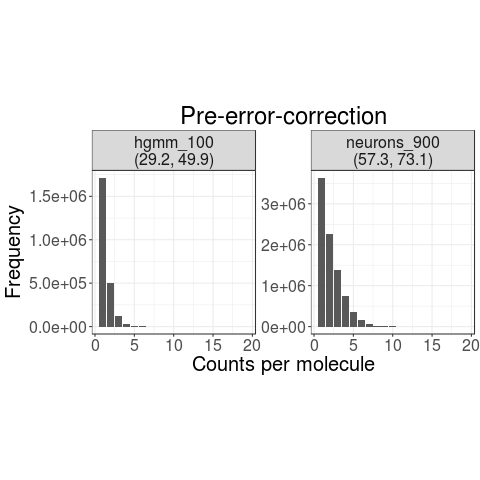

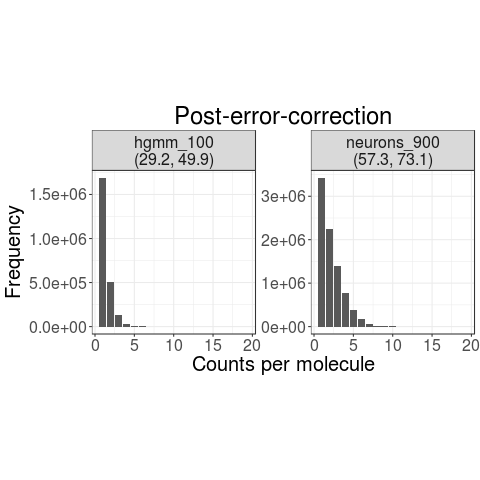

In [82]:
%%R -i counts_per_umi_df

counts_per_umi_df <- melt(counts_per_umi_df, id=c("counts", "sample", "sat", "dup", "label"))

p <- ggplot(counts_per_umi_df[counts_per_umi_df$variable=="instances_pre",],
            aes(counts, value)) + geom_bar(stat="identity") +
scale_y_continuous(labels = function(x) format(x, scientific = TRUE)) +
my_theme +
facet_wrap(~label, scale="free_y") +
ylab("Frequency") +
xlab("Counts per molecule") +
ggtitle("Pre-error-correction")

print(p)
ggsave(p, file="/home/FILESERVER5/proteomics/tss38/Desktop/plots/counts_1.png")

p2 <- p %+% counts_per_umi_df[counts_per_umi_df$variable=="instances_post",] +
ggtitle("Post-error-correction")

print(p2)
ggsave(p2, file="/home/FILESERVER5/proteomics/tss38/Desktop/plots/counts_2.png")

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


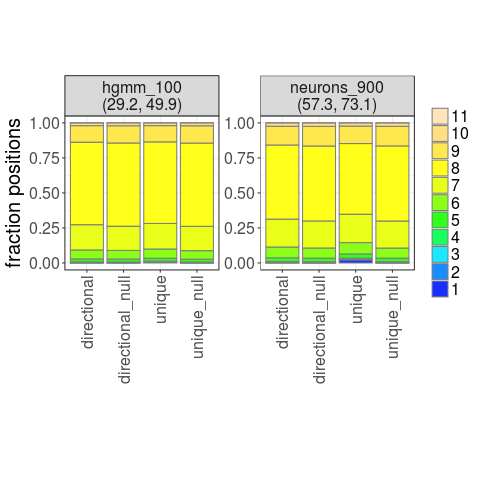

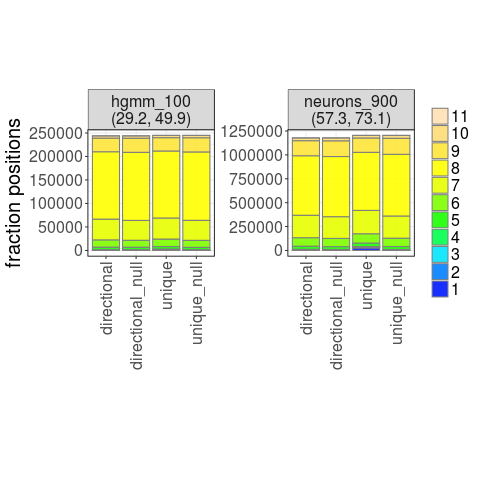

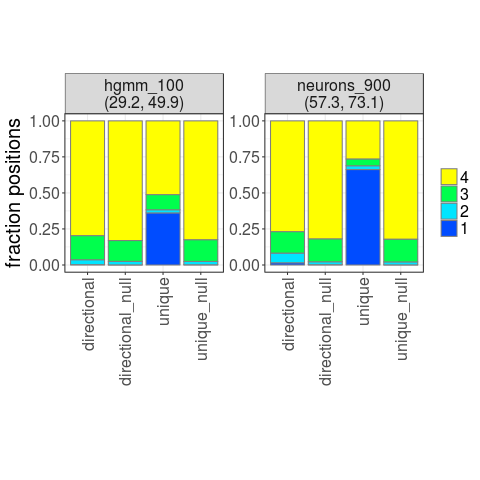

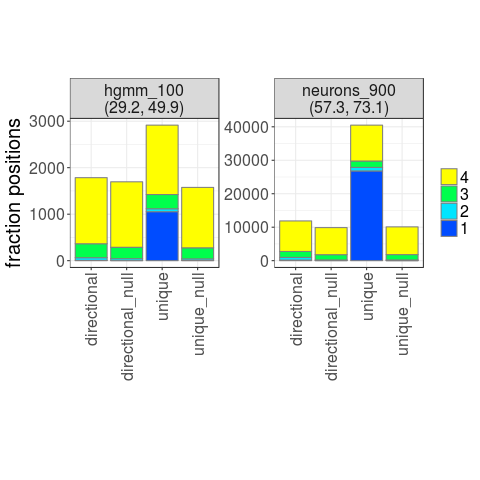

In [81]:
%%R -i edit_distance_df


edit_distance_df <- melt(edit_distance_df, id=c("edit_distance", "sample", "sat", "dup", "label"))
edit_distance_df <- edit_distance_df[!edit_distance_df$edit_distance %in% c("Single_UMI", "0"),]
edit_distance_df$edit_distance <- as.numeric(as.character(edit_distance_df$edit_distance))

p <- ggplot(edit_distance_df,
            aes(variable, value,
                fill=factor(edit_distance, levels=max(edit_distance_df$edit_distance):1))) +
my_theme +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
scale_fill_manual(name="", values=rev(topo.colors(max(edit_distance_df$edit_distance)+1, alpha = 0.9))) +
ylab("fraction positions") + xlab("") +
facet_wrap(~label, scale="free")

p1 <- p + geom_bar(position="fill", stat="identity", colour="grey50")
p2 <- p + geom_bar(stat="identity", colour="grey50")

print(p1)
ggsave(p1, file="/home/FILESERVER5/proteomics/tss38/Desktop/plots/edit_distance_1.png")
print(p2)
ggsave(p2, file="/home/FILESERVER5/proteomics/tss38/Desktop/plots/edit_distance_2.png")

small_distances_df <- edit_distance_df[edit_distance_df$edit_distance<5,]

p1.2 <- p1 %+%  small_distances_df +
      scale_fill_manual(name="", values=rev(topo.colors(max(small_distances_df$edit_distance)+1)))

p2.2 <- p2 %+%  small_distances_df +
      scale_fill_manual(name="", values=rev(topo.colors(max(small_distances_df$edit_distance)+1)))


print(p1.2)
ggsave(p1.2, file="/home/FILESERVER5/proteomics/tss38/Desktop/plots/edit_distance_1_2.png")
print(p2.2)
ggsave(p2.2, file="/home/FILESERVER5/proteomics/tss38/Desktop/plots/edit_distance_2_2.png")
